# Titanic Dataset Preprocessing and PSO Optimization

This notebook covers preprocessing the Titanic dataset and using Particle Swarm Optimization (PSO) for optimizing a custom objective function.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler     
import warnings
import time
import random
warnings.filterwarnings("ignore", category=FutureWarning)

## Loading and Preprocessing the Titanic Dataset

In [2]:
# Load Titanic dataset
print("Loading Titanic dataset...")
titanic_data = pd.read_csv('./data/train.csv')
print(f"Dataset loaded successfully with {titanic_data.shape[0]} rows and {titanic_data.shape[1]} columns.")

Loading Titanic dataset...
Dataset loaded successfully with 891 rows and 12 columns.


## Drop 'Cabin' column and fill missing values

In [3]:
# Check the columns of the dataset
print(titanic_data.columns)

# Drop 'Cabin' column if it exists
if 'Cabin' in titanic_data.columns:
    titanic_data = titanic_data.drop(columns='Cabin', axis=1)
    print("Dropped 'Cabin' column.")
else:
    print("'Cabin' column not found. Skipping drop operation.")




Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Dropped 'Cabin' column.


## Filling missing values

In [4]:
# Filling missing values
missing_values_before = titanic_data.isnull().sum()
titanic_data.fillna({'Age': titanic_data['Age'].mean(), 'Embarked': titanic_data['Embarked'].mode()[0]}, inplace=True)
missing_values_after = titanic_data.isnull().sum()

print("\nMissing values before processing:")
print(missing_values_before[missing_values_before > 0])
print("\nMissing values after processing:")
print(missing_values_after[missing_values_after > 0])

# Replace categorical values with numerical encoding
titanic_data['Sex'] = titanic_data['Sex'].map({'male': 0, 'female': 1}).astype(int)
titanic_data['Embarked'] = titanic_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
print("\nReplaced categorical values with numerical encoding.")


Missing values before processing:
Age         177
Embarked      2
dtype: int64

Missing values after processing:
Series([], dtype: int64)

Replaced categorical values with numerical encoding.


## Split features and target

In [5]:
# Split features and target
X = titanic_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Survived'], axis=1)
Y = titanic_data['Survived']
print("\nFeatures and target variables separated.")

# Split dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
print(f"\nSplit dataset into training (80%) and testing (20%) sets.")
print(f"Training set: {X_train.shape[0]} samples, Testing set: {X_test.shape[0]} samples.")

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
print("\nImputed missing values in training and testing sets.")


Features and target variables separated.

Split dataset into training (80%) and testing (20%) sets.
Training set: 712 samples, Testing set: 179 samples.

Imputed missing values in training and testing sets.


## Scale features & Summary

In [6]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("\nScaled feature values using StandardScaler.")

# Summary of the processed data
print("\nData preprocessing complete!")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")



Scaled feature values using StandardScaler.

Data preprocessing complete!
Training set shape: (712, 7)
Testing set shape: (179, 7)


## Defining the PSO Algorithm

In [7]:
# ---- PSO Algorithm ----
# Solution class
class solution:
    def __init__(self):
        self.executionTime = None
        self.convergence = None
        self.bestIndividual = None
        self.objfname = None


##  PSO Algorithm

In [8]:
# PSO Algorithm
def PSO(objf, lb, ub, dim, PopSize, iters):
    Vmax = 6
    wMax = 0.9
    wMin = 0.2
    c1 = 2
    c2 = 2

    s = solution()
    if not isinstance(lb, list):
        lb = [lb] * dim
    if not isinstance(ub, list):
        ub = [ub] * dim

    vel = np.zeros((PopSize, dim))
    pBestScore = np.full(PopSize, float("inf"))
    pBest = np.zeros((PopSize, dim))
    gBest = np.zeros(dim)
    gBestScore = float("inf")
    pos = np.random.uniform(lb, ub, (PopSize, dim))
    convergence_curve = np.zeros(iters)

    print(f'PSO is optimizing "{objf.__name__}"')

    timerStart = time.time()
    for l in range(iters):
        for i in range(PopSize):
            for j in range(dim):
                pos[i, j] = np.clip(pos[i, j], lb[j], ub[j])

            fitness = objf(pos[i, :])

            if pBestScore[i] > fitness:
                pBestScore[i] = fitness
                pBest[i, :] = pos[i, :].copy()

            if gBestScore > fitness:
                gBestScore = fitness
                gBest = pos[i, :].copy()

        w = wMax - l * ((wMax - wMin) / iters)

        for i in range(PopSize):
            for j in range(dim):
                r1 = random.random()
                r2 = random.random()
                vel[i, j] = (
                    w * vel[i, j]
                    + c1 * r1 * (pBest[i, j] - pos[i, j])
                    + c2 * r2 * (gBest[j] - pos[i, j])
                )
                vel[i, j] = np.clip(vel[i, j], -Vmax, Vmax)
                pos[i, j] = pos[i, j] + vel[i, j]

        convergence_curve[l] = gBestScore
        if l % 10 == 0:
            print(f"Iteration {l+1}, Best Fitness: {gBestScore}")

    timerEnd = time.time()
    s.executionTime = timerEnd - timerStart
    s.convergence = convergence_curve
    s.bestIndividual = gBest
    s.objfname = objf.__name__

    return s

##  Running the PSO Optimization & Example

PSO is optimizing "objective_function"
Iteration 1, Best Fitness: 0.3693820224719101
Iteration 11, Best Fitness: 0.3693820224719101
Iteration 21, Best Fitness: 0.3693820224719101
Iteration 31, Best Fitness: 0.3693820224719101
Iteration 41, Best Fitness: 0.3693820224719101
Best Individual Found: [6.45392521]
Best Fitness Score: 0.3693820224719101


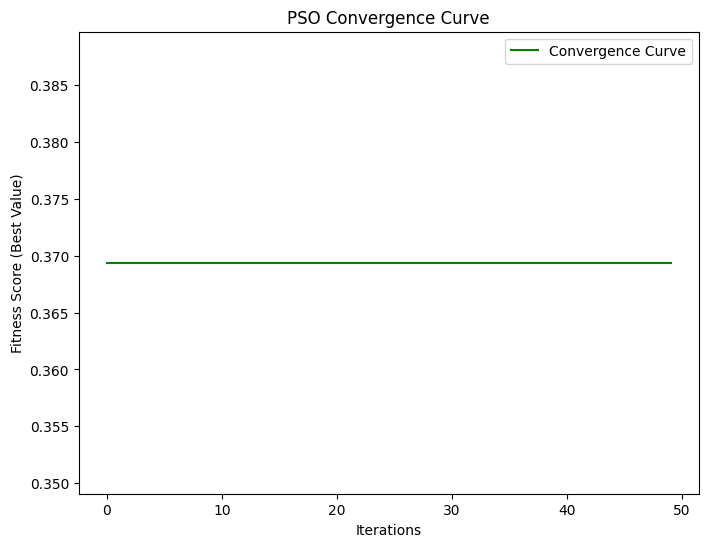

In [9]:
# Example of PSO usage with a simple objective function
def objective_function(params):
    threshold = params[0]
    predictions = (X_train[:, 0] > threshold).astype(int)  # Example prediction logic
    return 1 - accuracy_score(Y_train, predictions)  # Minimize error

# PSO Settings
lb = [-10]
ub = [10]
dim = 1
PopSize = 30
iters = 50

# Run PSO
best_solution = PSO(objective_function, lb, ub, dim, PopSize, iters)
print("Best Individual Found:", best_solution.bestIndividual)
print("Best Fitness Score:", best_solution.convergence[-1])

# 5. PSO Convergence Curve
plt.figure(figsize=(8, 6))
plt.plot(best_solution.convergence, label='Convergence Curve', color='green')
plt.title('PSO Convergence Curve')
plt.xlabel('Iterations')
plt.ylabel('Fitness Score (Best Value)')
plt.legend()
plt.show()

## Distribution of Age

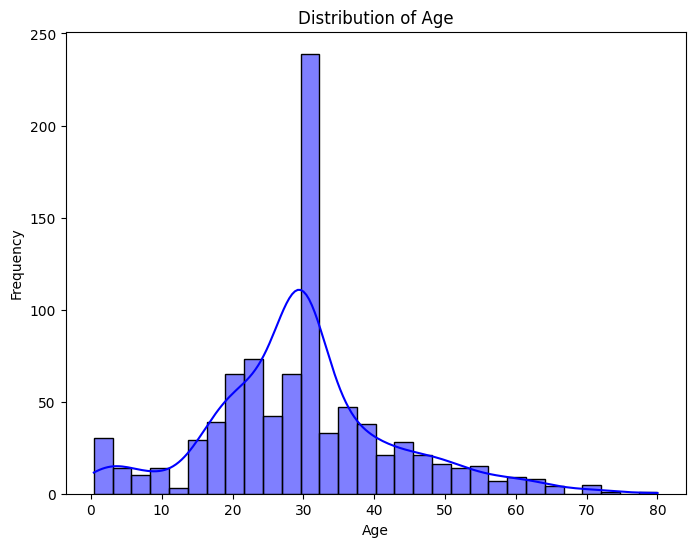

In [10]:
# 1. Distribution of Age
plt.figure(figsize=(8, 6))
sns.histplot(titanic_data['Age'], kde=True, color='blue', bins=30)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

## Gender Distribution

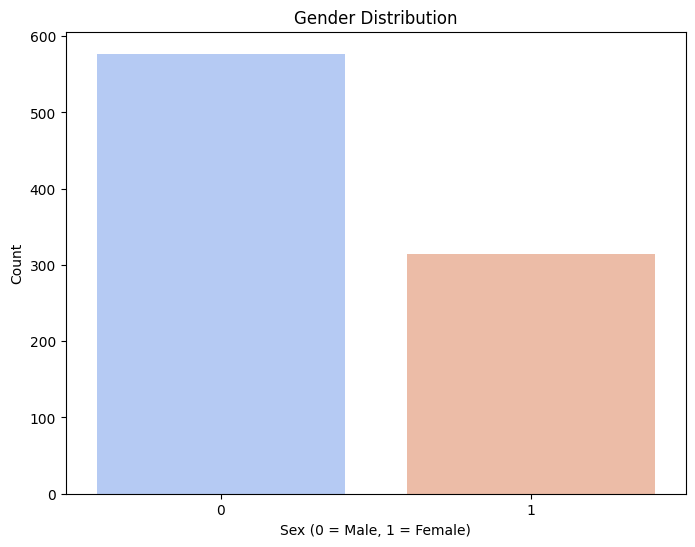

In [11]:
# 2. Gender Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sex', data=titanic_data, palette='coolwarm')
plt.title('Gender Distribution')
plt.xlabel('Sex (0 = Male, 1 = Female)')
plt.ylabel('Count')
plt.show()

## Embarked Port Distribution

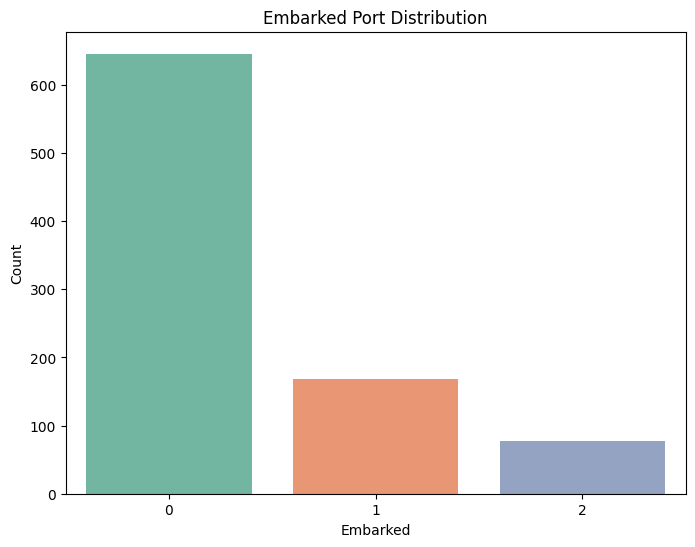

In [12]:
# 3. Embarked Port Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Embarked', data=titanic_data, palette='Set2')
plt.title('Embarked Port Distribution')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.show()

# Survived Distribution


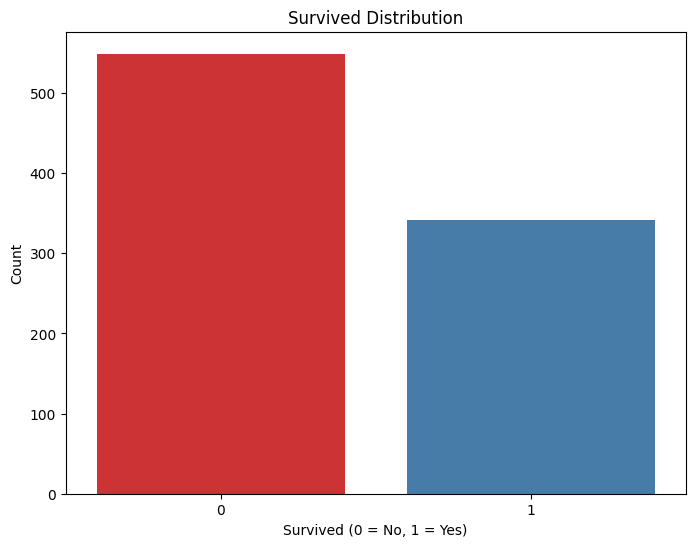

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Survived', data=titanic_data, palette='Set1')
plt.title('Survived Distribution')
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

## Correlation Matrix

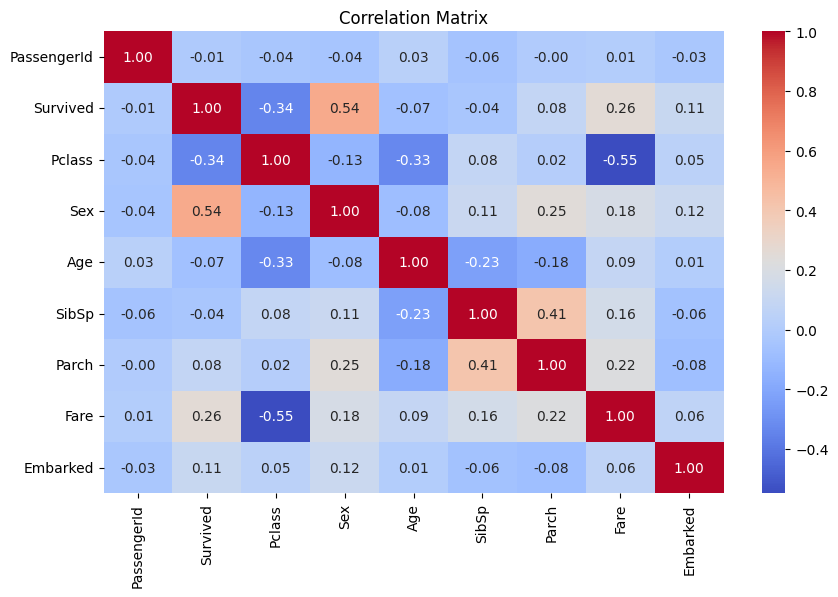

In [14]:
# 4. Correlation Matrix (Numerical Data Only)
numeric_data = titanic_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


## Defining the Objective Function

In [15]:
def objective_function(params):
    threshold = params[0]
    predictions = (X_train[:, 0] > threshold).astype(int)  # Example prediction logic
    return 1 - accuracy_score(Y_train, predictions)  # Minimize error
        